# Creating Synthetic/ Baseline Data 

## Import Necessary Libraries

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# blur the image
from scipy.ndimage import gaussian_filter

from scipy.ndimage import zoom

# for removing the background
import cv2

## Create and Save the Synthetic Data

In [ ]:
# Save location
save_path = "your_path_here/Synthetic_Data_smooth/"

In [ ]:
def capsid(origin=(0, 0), 
           type="partial",
           N=48, # N x N grid
           inner_radius=0.6): 
    
    ################################### Pre-Define the Capsid Patch ##################################
    x = np.linspace(-1, 1, N)
    X, Y = np.meshgrid(x, x)
    x0, y0 = origin
    
    ################################## Define the Capsid Parameters ##################################
    radius=0.9
    
    ###################################### Set the Fill Density ######################################
    
    if type == 'full':
        # Create a random fill density between 0.4 and 0.6
        fill_density = np.random.uniform(0.4, 0.6)
    
    elif type == 'partial':
        # Create a random fill density between 0.1 and 0.3
        fill_density = np.random.uniform(0.1, 0.3)
        
    else: # 'empty'
        # Create a random fill density between 0 and 0.1
        fill_density = np.random.uniform(0, 0.1)
    
    # Note: I used np.random.uniform(a, b). Here I could have also used Unif[a,b), b>a so that (b - a) * random() + a. 
    # Using uniform the samples are uniformly distributed over the half-open interval [low, high) (includes low, but excludes high)
        
    ######################################### Create the Capsid #######################################
        
    circle_Z = np.where((radius**2 >= (X - x0)**2 + (Y - y0)**2) & (radius**2 <= ((X - x0)**2 + (Y - y0)**2 + inner_radius**2)),
            1 / (((X - x0)**2 + (Y - y0)**2) + 1), # in the true case
            1) # in the false case
    circle_Z += np.where(radius**2 >= ((X - x0)**2 + (Y - y0)**2 + inner_radius**2),
            1 - fill_density * 1 / (((X - x0)**2 + (Y - y0)**2) + 1), # in the true case
            1) # in the false case

    gaussian_Z = gaussian_filter(circle_Z, sigma=1.5)

    # Crop the image on each side
    cropped_Z = gaussian_Z[2:-2, 2:-2]
    
    # resize the image to 48x48
    Z = zoom(cropped_Z, (48/cropped_Z.shape[0], 48/cropped_Z.shape[1]), order=3, mode='nearest') # this line is only for making smooth fake data
    
    ######################################## Normalize the Image #######################################

    # Convert to 8-bit image
    gray_Z = (Z * 255).astype(np.uint8)
    
    # Use CLAHE to increase contrast
    clahe = cv2.createCLAHE(clipLimit=1, tileGridSize=(1, 1))
    Z = clahe.apply(gray_Z)
    
    # Convert the image from grayscale to RGB
    Z = cv2.cvtColor(Z, cv2.COLOR_GRAY2RGB)
    
    return Z

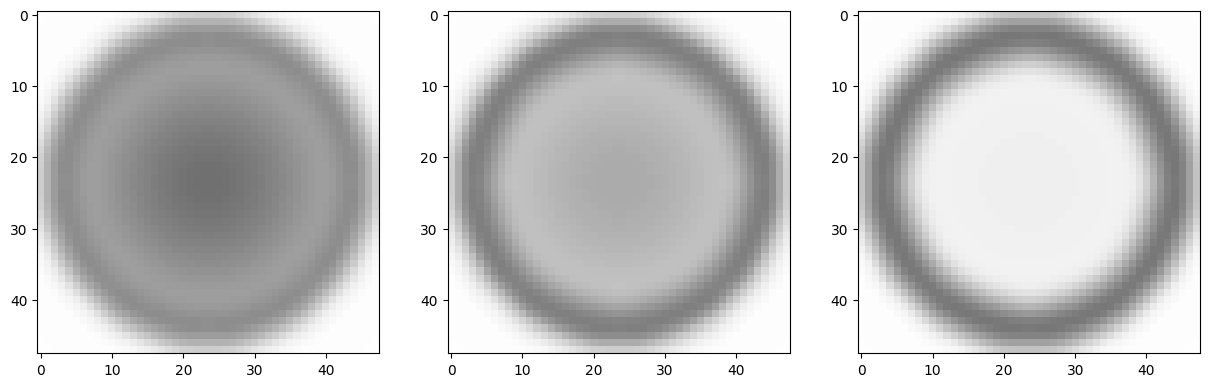

In [37]:
# Create a 1x3 grid of images
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].imshow(capsid(type="full"), cmap="gray")
ax[1].imshow(capsid(type="partial"), cmap="gray")
ax[2].imshow(capsid(type="empty"), cmap="gray")
plt.show()

In [ ]:
# Create a dataset of images with balanced number of partial, full, and empty capsids
N = 4017
capsids = []
labels = []
name = []

full_images = []
partial_images = []
empty_images = []

for i in range(N):
    if i in range(0, 4017//3):
        capsids.append(capsid(type="full"))
        labels.append(1)
        full_images.append(capsid(type="full"))
    elif i in range(4017//3, 2*4017//3):
        capsids.append(capsid(type="partial"))
        labels.append(2)
        partial_images.append(capsid(type="partial"))
    else:
        capsids.append(capsid(type="empty"))
        labels.append(3)
        empty_images.append(capsid(type="empty"))
    # Create a name for the image 
    name.append("image" + str(i))
        
# Save the dataset
np.save(save_path + "/capsids.npy", capsids)
np.save(save_path + "/labels.npy", labels)
np.save(save_path + "/name.npy", name)

# Save the image patches to the save_path
for i in range(N):
    plt.imsave(save_path + "synthetic_patches/image" + str(i) + ".png", capsids[i])

In [ ]:
# Create a dataframe to store the images and their labels

# Create a list of dictionaries
synthetic_data = []
for i in range(len(capsids)):
    synthetic_data.append({
        "name": name[i],
        "label": labels[i]
    })
    
# Create a dataframe
synthetic_data_df = pd.DataFrame(synthetic_data)

# Save the dataframe
synthetic_data_df.to_csv(save_path + "/synthetic_data.csv", index=False)

## Display the Images

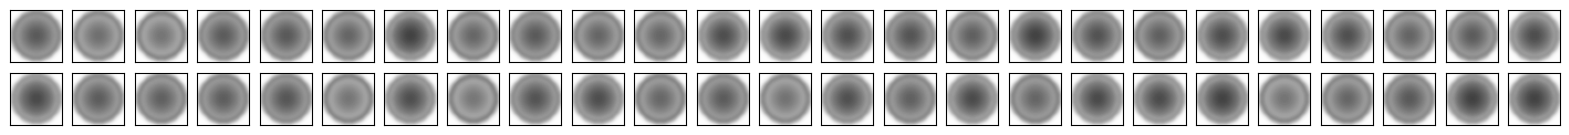

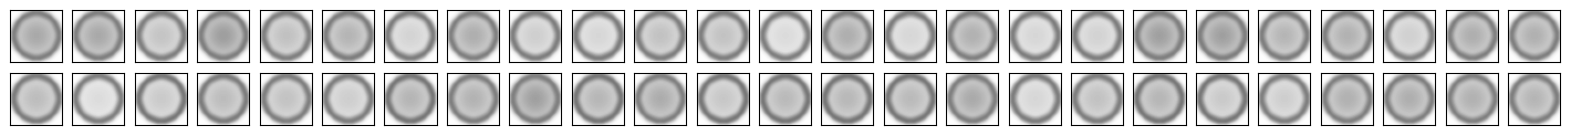

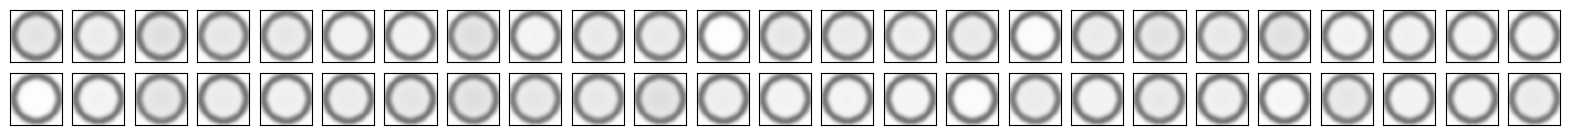

In [ ]:
# plot the images
def plot_images(images, labels, num_images, capsid_type):
    plt.figure(figsize=(20, 1.5))
    
    # Get full, partial, or empty images
    if capsid_type == 1:
        indices = [i for i in range(len(images)) if labels[i] == 1]
    elif capsid_type == 2:
        indices = [i for i in range(len(images)) if labels[i] == 2]
    else:
        indices = [i for i in range(len(images)) if labels[i] == 3]
    
    for i in range(num_images):
        if i < len(indices):
            index = indices[i]
            plt.subplot(2, num_images // 2, i + 1)  # Two rows of images
            plt.grid(False)
            # Remove the axis
            plt.xticks([])
            plt.yticks([])
            plt.imshow(images[index], cmap="gray")
    
    plt.show()

# Plot 50 full capsids
plot_images(capsids, labels, 50, 1)
# Plot 50 partial capsids
plot_images(capsids, labels, 50, 2)
# Plot 50 empty capsids
plot_images(capsids, labels, 50, 3)

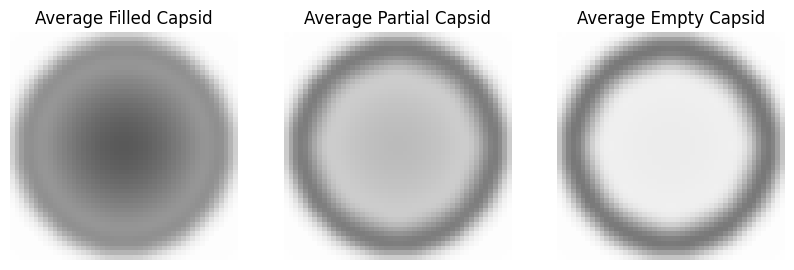

In [ ]:
# Convert the list of images to a numpy array
full_images_array = np.array(full_images)
partial_images_array = np.array(partial_images)
empty_images_array = np.array(empty_images)

# Convert the images to float type for accurate averaging
full_images_float = full_images_array.astype(np.float32)
partial_images_float = partial_images_array.astype(np.float32)
empty_images_float = empty_images_array.astype(np.float32)

# Compute the average images
avg_filled = np.mean(full_images_float, axis=0)
avg_partial = np.mean(partial_images_float, axis=0)
avg_empty = np.mean(empty_images_float, axis=0)

# Clip the values to [0, 255] range and convert back to uint8 for display
avg_filled = np.clip(avg_filled, 0, 255).astype(np.uint8)
avg_partial = np.clip(avg_partial, 0, 255).astype(np.uint8)
avg_empty = np.clip(avg_empty, 0, 255).astype(np.uint8)

plt.rcParams.update({'font.size': 10})

# plot both of the avg_empty and the avg_filled on subplots
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
# change the size of the figure
fig.set_size_inches(10, 10)

ax1.imshow(avg_filled, cmap='gray')
ax1.axis('off')
ax1.set_title('Average Filled Capsid')
ax2.imshow(avg_partial, cmap='gray')    
ax2.axis('off')
ax2.set_title('Average Partial Capsid')
ax3.imshow(avg_empty, cmap='gray')
ax3.axis('off')
ax3.set_title('Average Empty Capsid')
plt.show()
